In [1]:
import os
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from scipy.ndimage import distance_transform_edt

In [2]:
PATH_LINES = r"/Users/hester/Desktop/data/uk_transmission_lines.geojson" 
UK_SHP = r"/Users/hester/Desktop/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"

In [3]:
lines = gpd.read_file(PATH_LINES)
uk = None
if UK_SHP and os.path.exists(UK_SHP):
    world = gpd.read_file(UK_SHP)
    for col in ["NAME", "ADMIN", "SOVEREIGNT", "NAME_LONG", "BRK_NAME"]:
        if col in world.columns:
            uk = world[world[col].isin(["United Kingdom", "UK", "Britain"])].copy()
            if len(uk) > 0:
                break

if uk is None or len(uk) == 0:
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    uk = world[world["name"] == "United Kingdom"].copy()

target_crs = "EPSG:3857"
uk = uk.to_crs(target_crs)
lines = lines.to_crs(target_crs)

/opt/anaconda3/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: Several features with id = 3993385 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


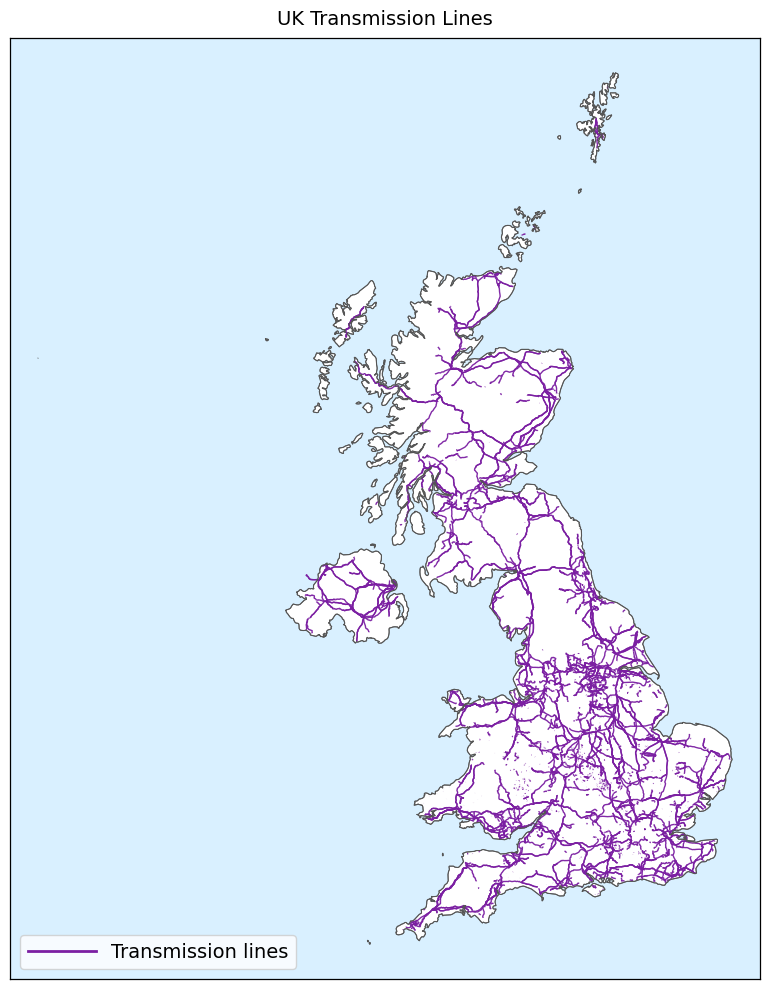

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

ax.set_facecolor("#d9f0ff")

uk.plot(ax=ax, color="white", edgecolor="#666666", linewidth=0.6, zorder=1)

lines.plot(ax=ax, color="#7b1fa2", linewidth=1.0, alpha=0.95, zorder=2)  # 紫色线

uk.boundary.plot(ax=ax, color="#555555", linewidth=0.8, zorder=3)

minx, miny, maxx, maxy = uk.total_bounds
padx = (maxx - minx) * 0.04
pady = (maxy - miny) * 0.04
ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)

ax.set_title("UK Transmission Lines", fontsize=14, pad=10)

# legend
legend_items = [
    Line2D([0], [0], color="#7b1fa2", lw=2, label="Transmission lines"),
]
ax.legend(handles=legend_items, loc="lower left", fontsize=14, labelspacing=1.2,handlelength=3.5)
ax.set_xticks([]); ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.9)
    spine.set_edgecolor("black")
plt.tight_layout()
plt.show()
fig.savefig("UK Transmission Lines.png", dpi=300, bbox_inches="tight")

In [5]:
OUT_TIF= "/Users/hester/Desktop/data/tra_binary.tif"

In [6]:
CRS_METRIC = "EPSG:27700"   # 英国国家格网，单位 m
RES = 250                   # 栅格分辨率（m）。250m比较顺滑且不太慢；想更细可用 100
PAD = 20000                 # 边界外扩（m），让图更好看

In [7]:
lines = gpd.read_file(PATH_LINES)

world = gpd.read_file(UK_SHP)
uk = None
for col in ["ADMIN", "NAME", "SOVEREIGNT", "NAME_LONG", "BRK_NAME"]:
    if col in world.columns:
        uk_try = world[world[col].isin(["United Kingdom", "UK", "Britain"])].copy()
        if len(uk_try) > 0:
            uk = uk_try
            break
if uk is None or len(uk) == 0:
    raise ValueError("在你的 countries shp 里没筛到 United Kingdom。请检查字段名/属性值。")


uk = uk.to_crs(CRS_METRIC)
lines = lines.to_crs(CRS_METRIC)

uk_geom = uk.geometry.unary_union

/opt/anaconda3/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: Several features with id = 3993385 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(
/var/folders/t7/mdmmjjzs7svdzv7rr3xllsgh0000gn/T/ipykernel_10052/1514792453.py:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  uk_geom = uk.geometry.unary_union


In [8]:
minx, miny, maxx, maxy = uk.total_bounds
minx -= PAD; miny -= PAD; maxx += PAD; maxy += PAD

width = int(np.ceil((maxx - minx) / RES))
height = int(np.ceil((maxy - miny) / RES))

transform = from_origin(minx, maxy, RES, RES)

In [9]:
uk_mask = rasterize(
    [(uk_geom, 1)],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype="uint8"
)

line_r = rasterize(
    [(geom, 1) for geom in lines.geometry if geom is not None],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype="uint8"
)

In [10]:
dist_pixels = distance_transform_edt(line_r == 0)
dist_m = dist_pixels * RES

suit = np.zeros_like(dist_m, dtype="float32")
suit[(dist_m >= 0) & (dist_m < 5000)] = 1.0
suit[(dist_m >= 5000) & (dist_m < 10000)] = 0.6
suit[(dist_m >= 10000) & (dist_m < 20000)] = 0.3
suit[(dist_m >= 20000)] = 0.0

suit[uk_mask == 0] = np.nan

In [11]:
profile = {
    "driver": "GTiff",
    "height": height,
    "width": width,
    "count": 1,
    "dtype": "float32",
    "crs": CRS_METRIC,
    "transform": transform,
    "nodata": np.nan
}

with rasterio.open(OUT_TIF, "w", **profile) as dst:
    dst.write(suit, 1)
print("Saved:", OUT_TIF)

Saved: /Users/hester/Desktop/data/tra_binary.tif


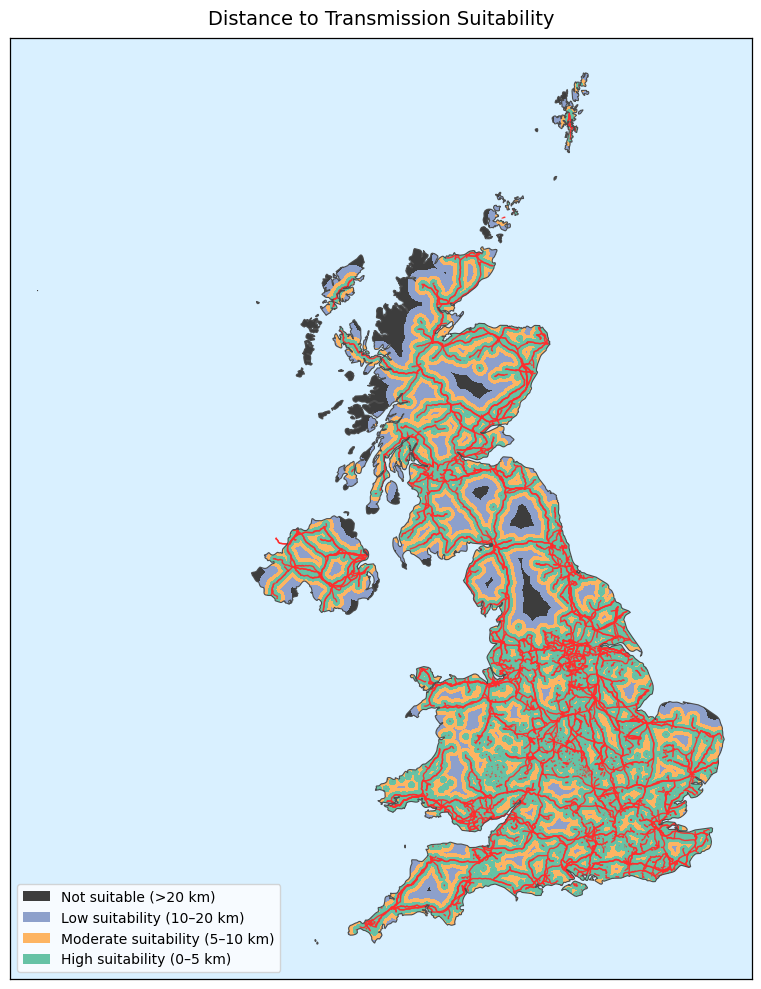

In [12]:
cmap = ListedColormap(["#3d3d3d", "#8da0cb", "#fdb462", "#66c2a5"])
cmap.set_bad((0, 0, 0, 0)) 

bounds = [-0.01, 0.15, 0.45, 0.8, 1.01]
norm = BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(1, 1, figsize=(8, 10))
#fig.patch.set_facecolor("#d9f0ff")
ax.set_facecolor("#d9f0ff")

left, top = transform * (0, 0)
right, bottom = transform * (width, height)

extent = (left, right, bottom, top)  

im = ax.imshow(
    suit,
    cmap=cmap,
    norm=norm,
    extent=extent,
    origin="upper",
    interpolation="nearest",
    zorder=1
)

lines.plot(ax=ax, color="#ff2d2d", linewidth=1.0, alpha=0.95, zorder=3)

gpd.GeoSeries([uk_geom], crs=CRS_METRIC).boundary.plot(
    ax=ax, color="#4d4d4d", linewidth=0.8, zorder=4
)
minx, miny, maxx, maxy = uk_geom.bounds
padx = (maxx - minx) * 0.04
pady = (maxy - miny) * 0.04

ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)

ax.set_aspect("equal", adjustable="box")
ax.set_title("Distance to Transmission Suitability", fontsize=14, pad=10)

legend_items = [
    Patch(facecolor=cmap(0), label="Not suitable (>20 km)"),
    Patch(facecolor=cmap(1), label="Low suitability (10–20 km)"),
    Patch(facecolor=cmap(2), label="Moderate suitability (5–10 km)"),
    Patch(facecolor=cmap(3), label="High suitability (0–5 km)"),
]
ax.legend(handles=legend_items, loc="lower left", fontsize=10, frameon=True)
ax.set_xticks([]); ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.9)
    spine.set_edgecolor("black")
plt.tight_layout()
plt.show()
fig.savefig("Distance to Transmission Suitability.png", dpi=300, bbox_inches="tight")